In [7]:
import pandas as pd
import numpy as np
import os

import nibabel as nib
import matplotlib.pyplot as plt
import seaborn as sns

from monai.transforms import (
    Compose,
    MapTransform,
    LoadImaged,
    ScaleIntensityRanged,
    ScaleIntensityRangePercentilesd
)

from monai.data import DataLoader, Dataset

# Visualization of voxels intensity distribution

In [3]:
metadatas = []

for folder in os.listdir('../data/raw'):
    folder_path = os.path.join('..', 'data', 'raw', folder)
    if not os.path.isdir(folder_path): # skip if not a directory
        continue
    if folder.startswith('labels') or folder.startswith('itksnap'): # skip labels files
        continue

    for file in os.listdir(folder_path):
        if file.endswith('.nii') or file.endswith('.nii.gz'):
            file_path = os.path.join(folder_path, file)
            file_name = file
            modality = file.split('_')[1]

            metadatas.append({'file_name': file_name, 'file_path': file_path, 'modality': modality})

df = pd.DataFrame(metadatas)
df.head()


,file_name,file_path,modality
0,topcow_ct_025_0000.nii.gz,../data/raw/imagesTr_topbrain_ct/topcow_ct_025...,ct
1,topcow_ct_015_0000.nii.gz,../data/raw/imagesTr_topbrain_ct/topcow_ct_015...,ct
2,topcow_ct_022_0000.nii.gz,../data/raw/imagesTr_topbrain_ct/topcow_ct_022...,ct
3,topcow_ct_017_0000.nii.gz,../data/raw/imagesTr_topbrain_ct/topcow_ct_017...,ct
4,topcow_ct_020_0000.nii.gz,../data/raw/imagesTr_topbrain_ct/topcow_ct_020...,ct


In [4]:
# Visualization of voxels intensity distribution for CTA modalities

cta_files = df[df['modality'] == 'ct'] # filter for CTA modalities
all_distributions_cta = []

for idx, row in cta_files.iterrows():
    img = nib.load(row['file_path']) # load the NIfTI file
    data = img.get_fdata() # get the image data as a numpy array
    data_flat = data.flatten() # flatten the array to 1D
    data_flat = np.random.choice(data_flat, size=10000, replace=False) # sample 10,000 voxels for visualization

    all_distributions_cta.append(pd.DataFrame({
        'intensity': data_flat,
        'image': row['file_name']
    })) # append the DataFrame to the list

all_distributions_cta_df = pd.concat(all_distributions_cta, ignore_index=True)

# Visualization of voxels intensity distribution for MRA modalities

mra_files = df[df['modality'] == 'mr'] # filter for MRA modalities
all_distributions_mra = []

for idx, row in mra_files.iterrows():
    img = nib.load(row['file_path']) # load the NIfTI file
    data = img.get_fdata() # get the image data as a numpy array
    data_flat = data.flatten() # flatten the array to 1D
    data_flat = np.random.choice(data_flat, size=10000, replace=False) # sample 10,000 voxels for visualization

    all_distributions_mra.append(pd.DataFrame({
        'intensity': data_flat,
        'image': row['file_name']
    })) # append the DataFrame to the list

all_distributions_mra_df = pd.concat(all_distributions_mra, ignore_index=True)


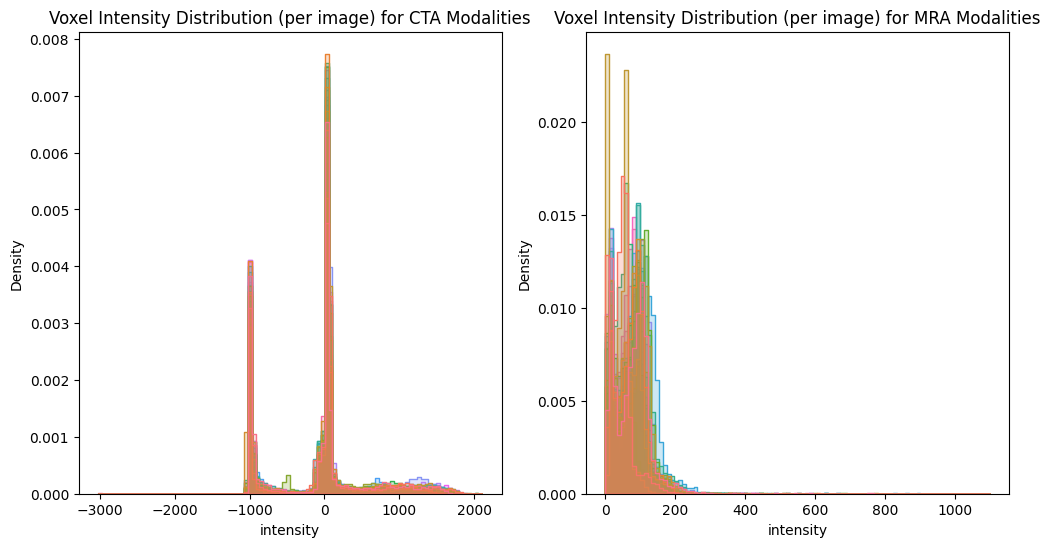

In [5]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(data=all_distributions_cta_df, x="intensity", hue="image", element="step", bins=100, stat="density", common_norm=False, legend=False)
plt.title('Voxel Intensity Distribution (per image) for CTA Modalities')

plt.subplot(1, 2, 2)
sns.histplot(data=all_distributions_mra_df, x="intensity", hue="image", element="step", bins=100, stat="density", common_norm=False, legend=False)
plt.title('Voxel Intensity Distribution (per image) for MRA Modalities')

plt.show()

In [6]:
data_dict = []

for idx, row in df.iterrows():
    data_dict.append({"image": row['file_path'], "label": np.nan, "modality": row['modality']})

class CustomScaleIntensityRanged(MapTransform):
    def __init__(self, keys: list, min: float = 0.0, max: float = 1.0):
        super().__init__(keys)
        self.min = min
        self.max = max
        self.ct_transform = ScaleIntensityRanged(
            keys=keys, a_min=-200, a_max=800, b_min=min, b_max=max, clip=True)
        self.mr_transform = ScaleIntensityRangePercentilesd(
            keys=keys, lower=0.5, upper=99.5, b_min=min, b_max=max, 
            clip=True, relative=False, channel_wise=False)

    def __call__(self, data: dict) -> dict:
        d = dict(data)
        if d["modality"] == "ct":
            d = self.ct_transform(d)
        elif d["modality"] == "mr":
            d = self.mr_transform(d)
        else:
            raise ValueError(f"Unsupported modality: {d['modality']}")
        return d

transforms = Compose([
    LoadImaged(keys=["image"]),
    CustomScaleIntensityRanged(keys=["image"], min=0.0, max=1.0)
])

In [13]:
ds = Dataset(data=data_dict, transform=transforms)
loader = DataLoader(ds, batch_size=1, shuffle=False)

all_distributions_cta = []
all_distributions_mra = []

for idx, data in enumerate(loader):
    img = data['image'][0]  # get the image tensor
    img = img.numpy()  # convert to numpy array
    img_flat = img.flatten()  # flatten the array to 1D
    img_flat = np.random.choice(img_flat, size=10000, replace=False)  # sample 10,000 voxels for visualization

    if data['modality'][0] == 'ct':
        all_distributions_cta.append(pd.DataFrame({
            'intensity': img_flat,
            'image': idx
        }))  # append the DataFrame to the list
    elif data['modality'][0] == 'mr':
        all_distributions_mra.append(pd.DataFrame({
            'intensity': img_flat,
            'image': idx
        }))  # append the DataFrame to the list

all_distributions_cta_df = pd.concat(all_distributions_cta, ignore_index=True)
all_distributions_mra_df = pd.concat(all_distributions_mra, ignore_index=True)


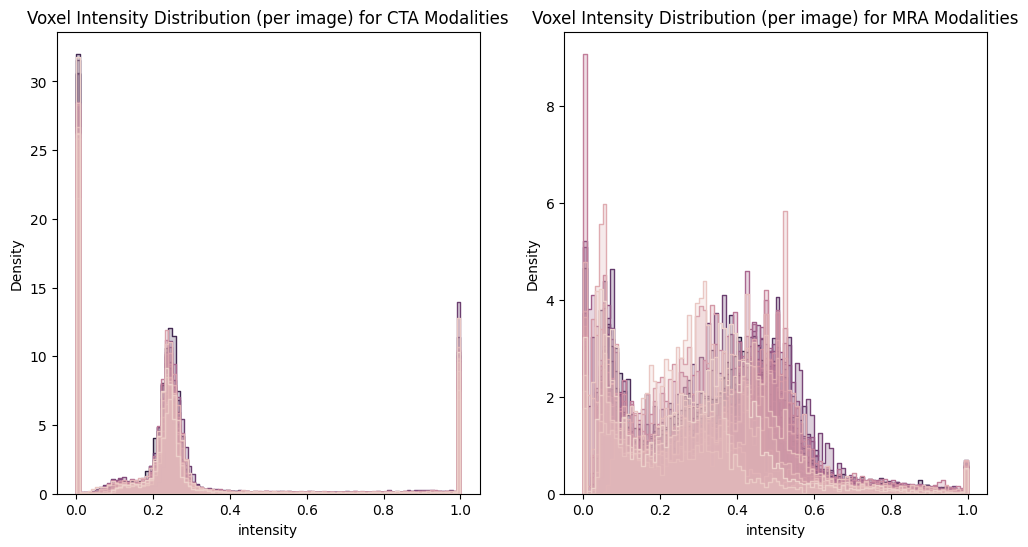

In [14]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(data=all_distributions_cta_df, x="intensity", hue="image", element="step", bins=100, stat="density", common_norm=False, legend=False)
plt.title('Voxel Intensity Distribution (per image) for CTA Modalities')

plt.subplot(1, 2, 2)
sns.histplot(data=all_distributions_mra_df, x="intensity", hue="image", element="step", bins=100, stat="density", common_norm=False, legend=False)
plt.title('Voxel Intensity Distribution (per image) for MRA Modalities')

plt.show()